In [1]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [4]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()
                         ).to(def_device)

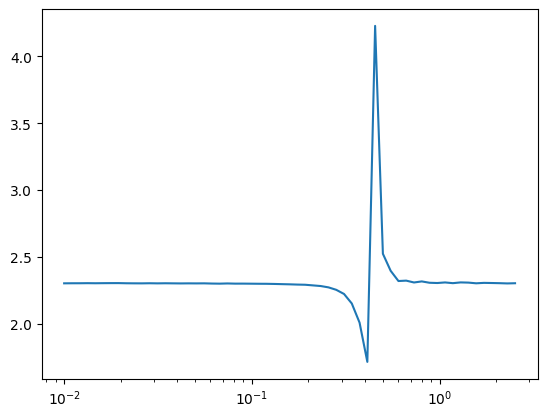

In [24]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2, max_epochs=1)

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.122,2.323,0,train
0.100,2.303,0,eval


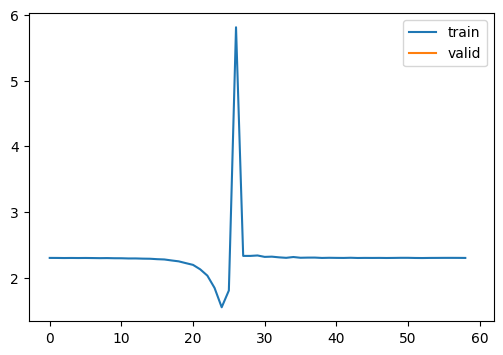

In [26]:
learn.fit(1)

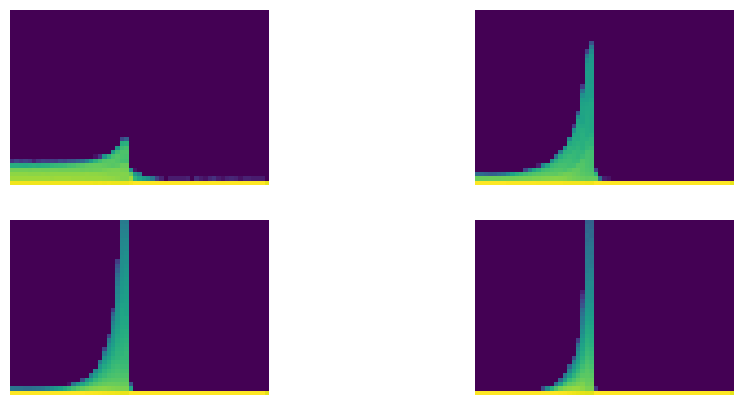

In [27]:
astats.color_dim()

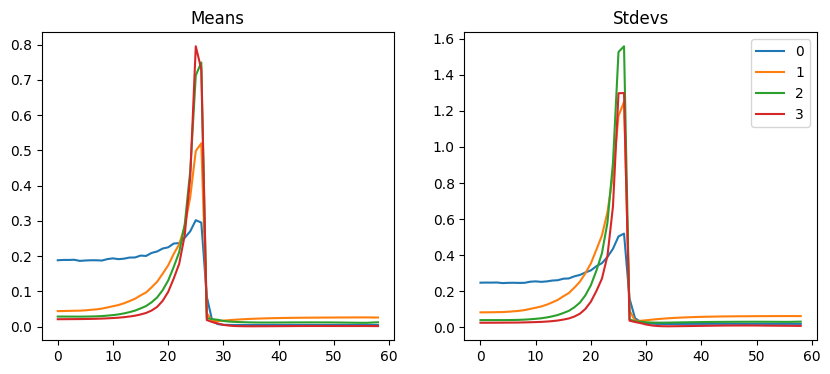

In [28]:
astats.plot_stats()

NB very bad behaviour, and although ends with mean ~0 the stdevs are also around 0! So there's nothing going on...

### Utility functions

In [6]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [7]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [8]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [52]:
clean_mem()

## Xavier init

Initialise with mean 0, std 1 but multiply matrices and we have a multiplier/gain equal to the number of inputs (inner dimension of our weight matrix and dimension of input matrix)

In [33]:
mean,sqr = 0.,0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(0.05342885512858629, 98.2300611114502)

simply results from summing n=100 values of products of one value of a with one of x, each having std=1

we can setup an example with 100 individual multiplies of independent values to correspond to our matrix-vector product, and do this 100 times to get something statistically useful as above we'll have the following.

the mean of squares is approx 100, so if we divide as initialisation by `sqrt(100)`, we'll get back to std 1

In [35]:
mean, sqr = 0., 0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a * x
    mean += y.item()
    sqr += y.pow(2).item()
mean / 10000, sqr / 10000

(-0.0014766466953555209, 0.9700104275686424)

### Kaiming He init (ReLU)

This is all fine until asymetric activations like ReLU are applied. This init fixes it in the simplest way:

- do the same as for symmetric activations but multiply by `2`

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.


In [9]:
# This fails
def relu(x): return x.clamp_min(0.)
x = torch.randn(200, 100)
for _ in range(50): x = relu(x @ (torch.randn(100, 100) * 0.1))
x[0:5, 0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In [9]:
# This works
def relu(x): return x.clamp_min(0.)
x = torch.randn(200, 100)
for _ in range(50): x = relu(x @ (torch.randn(100, 100) * torch.tensor(2 / 100).sqrt()))
x[0:5, 0:5]

tensor([[1.20, 0.12, 0.84, 0.88, 0.00],
        [0.48, 0.03, 0.31, 0.39, 0.00],
        [0.85, 0.02, 0.56, 0.71, 0.00],
        [1.09, 0.11, 0.68, 0.88, 0.00],
        [1.12, 0.12, 0.73, 0.91, 0.00]])

In [10]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight)

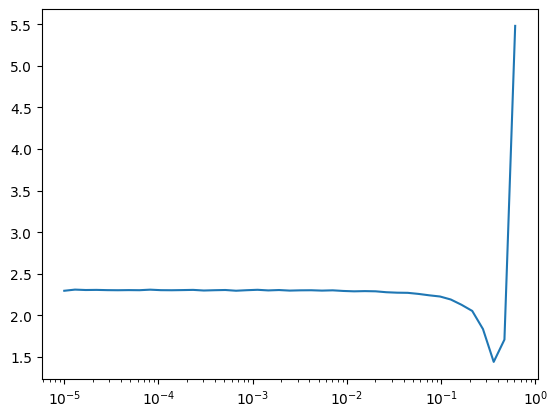

In [12]:
model = get_model()
model.apply(init_weights);
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

accuracy,loss,epoch,train
0.649,1.065,0,train
0.811,0.524,0,eval
0.831,0.460,1,train
0.840,0.427,1,eval
0.854,0.400,2,train
0.831,0.454,2,eval


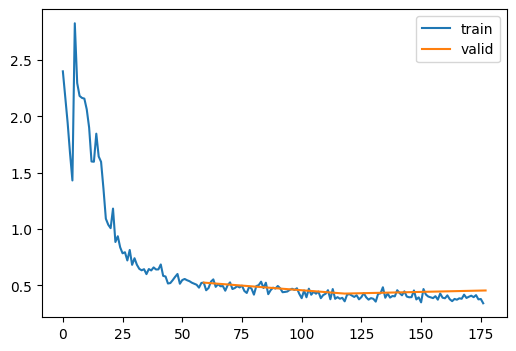

In [14]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.19, cbs=cbs)
learn.fit(3)

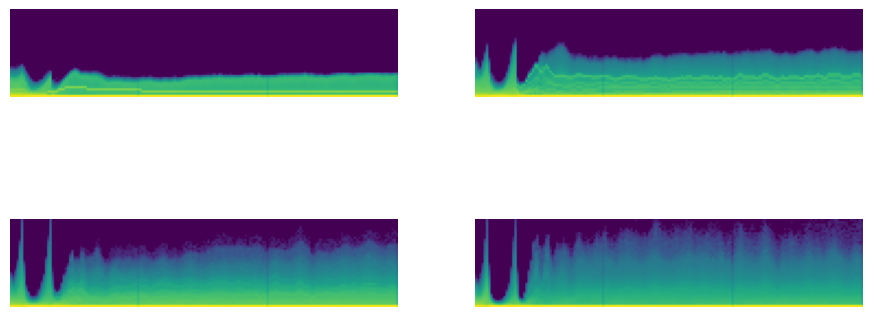

In [66]:
astats.color_dim()

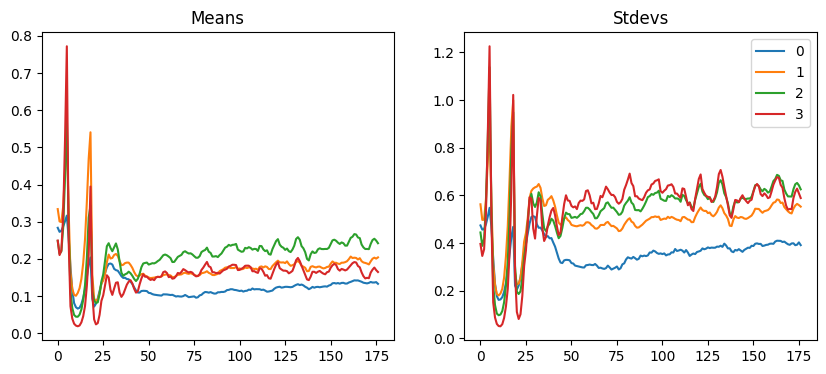

In [67]:
astats.plot_stats()

## Input normalisation

In [11]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd     

(tensor(0.29), tensor(0.35))

In [12]:
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_valid=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): learn.batch = self.tfm(learn.batch)

In [13]:
def _norm(b): return (b[0] - xmean) / xstd, b[1]
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.558,1.355,0,train
0.768,0.606,0,eval
0.814,0.504,1,train
0.820,0.482,1,eval
0.846,0.419,2,train
0.826,0.456,2,eval


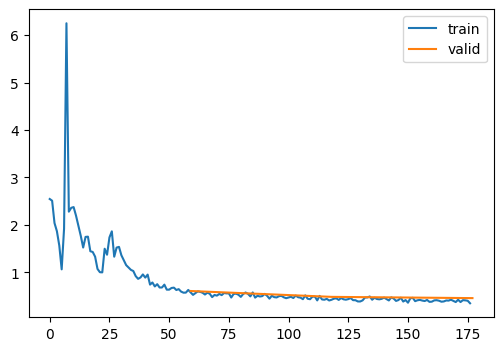

In [18]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

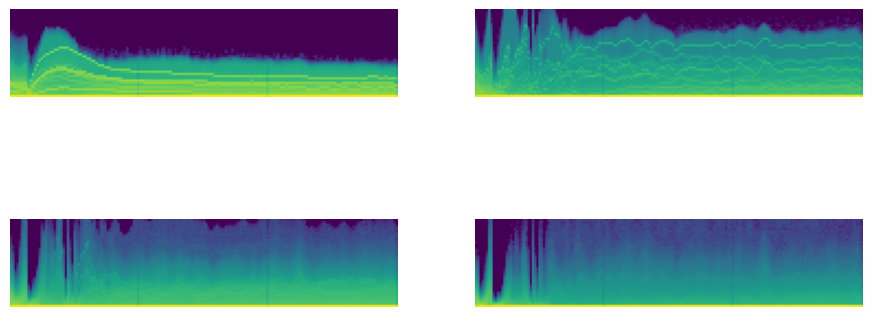

In [19]:
astats.color_dim()

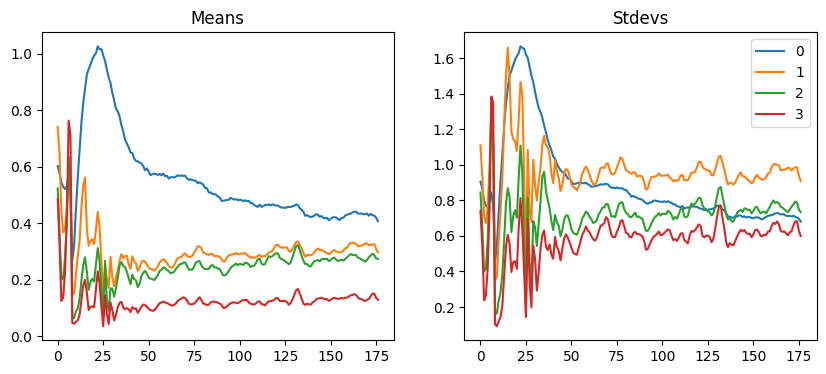

In [20]:
astats.plot_stats()

In [14]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb,yb = next(iter(dls.train))

In [15]:
xb.mean(), xb.std()

(tensor(0.01), tensor(1.00))

## General ReLU

In [16]:
class GeneralReLU(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else nn.ReLU(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_(self.maxv)
        return x

In [17]:
#| export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

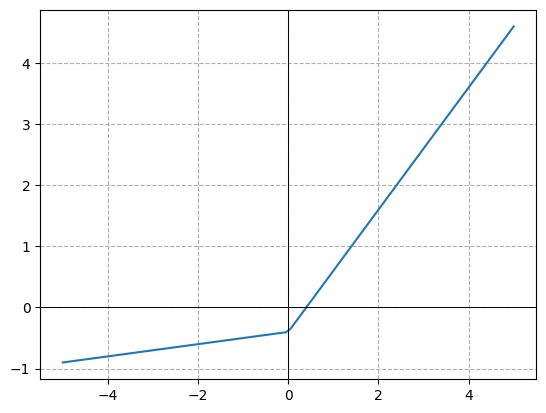

In [18]:
plot_func(GeneralReLU(leak=0.1, sub=0.4))

In [19]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [20]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs) -1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(def_device)

In [21]:
# NB variable called `leaky` here but `leak` in GeneralReLU init. Keep as is to avoid bugs if forgotten but should have the same names!
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [22]:
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [23]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.780,0.619,0,train
0.847,0.424,0,eval
0.863,0.372,1,train
0.863,0.370,1,eval
0.879,0.329,2,train
0.867,0.361,2,eval


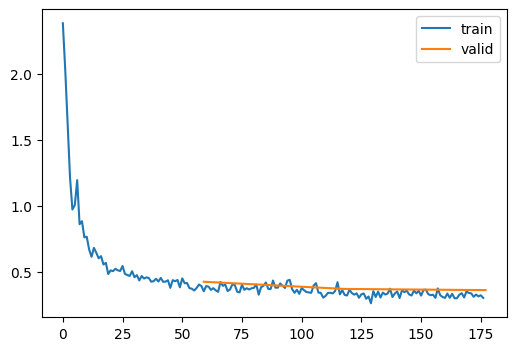

In [24]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

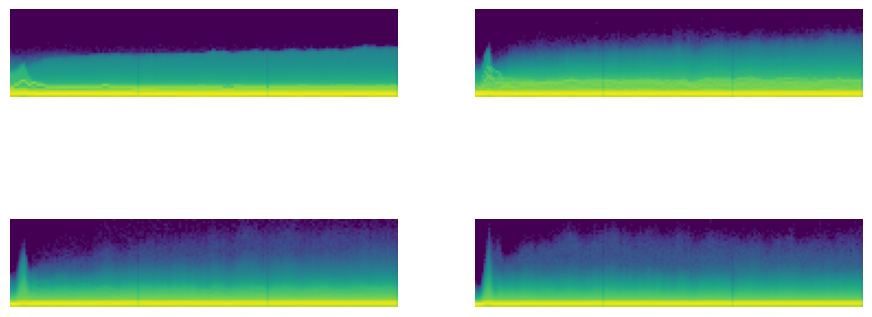

In [25]:
astats.color_dim()

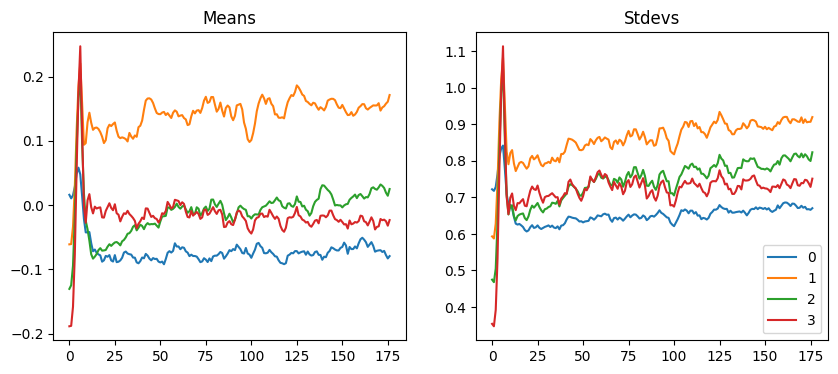

In [26]:
astats.plot_stats()

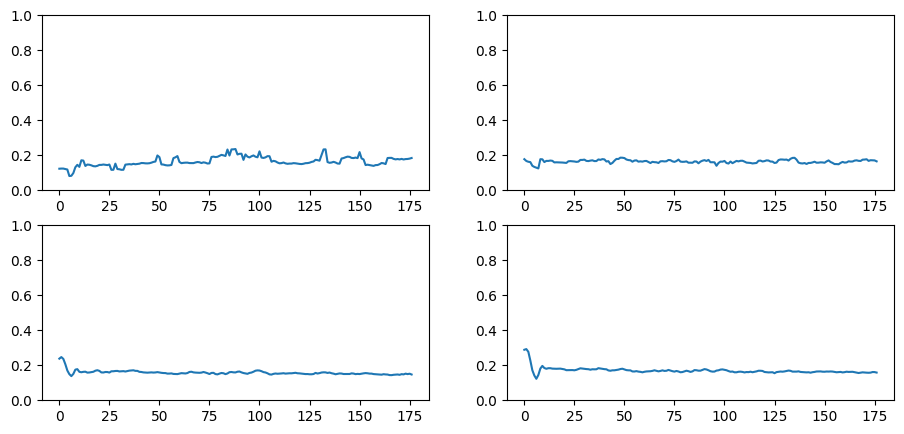

In [27]:
astats.dead_chart()

## LSUV

[All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf) introduces *Layer-wise Sequential Unit-Variance* (*LSUV*).

In [63]:
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, mod, mod_in, xb):
    # check if the output of each ReLU is normalised, and if not, normalise the weight/bias
    # of the preceeding conv layer
    h = Hook(mod, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1) > 1e-3 or abs(h.mean) > 1e-3):
            mod_in.bias -= h.mean
            mod_in.weight.data /= h.std
    h.remove()

In [54]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralReLU)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [55]:
for ms in zip(relus, convs): print(ms)

(GeneralReLU(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralReLU(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralReLU(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralReLU(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [56]:
for ms in zip(relus, convs): lsuv_init(model, *ms, xb.to(def_device))

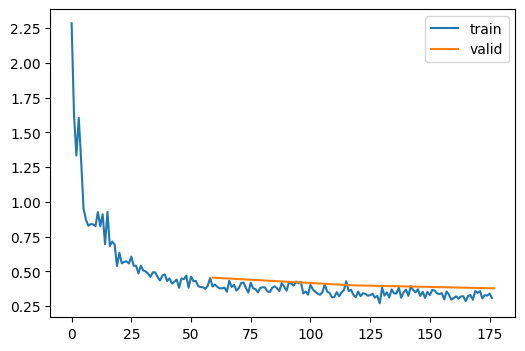

In [57]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

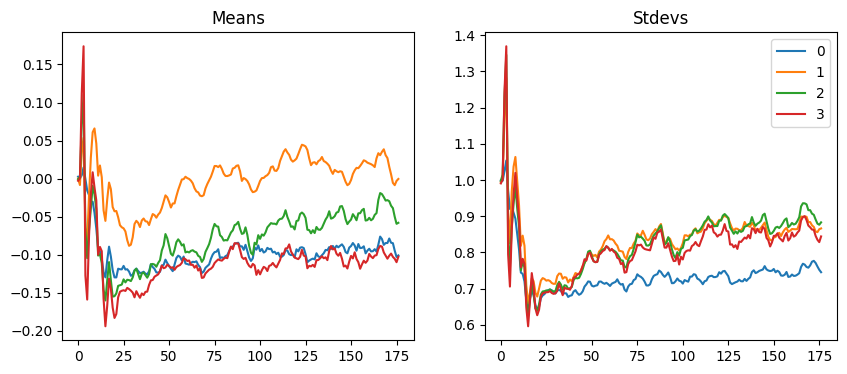

In [58]:
astats.plot_stats()

In [64]:
class LSUVCallback(Callback):
    def __init__(self, xb):
        self.xb = xb
        self.first_run = True

    def before_fit(self, learn):
        if not self.first_run: 
            if self in learn.cbs: learn.cbs.remove(self)
            return
        
        xbd = xb.to(def_device)
        relus = [o for o in model.modules() if isinstance(o, GeneralReLU)]
        convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]
        for ms in zip(relus, convs): lsuv_init(model, *ms, xbd)
        
        self.first_run = False

In [65]:
lsuvcb = LSUVCallback(xb)

accuracy,loss,epoch,train
0.770,0.656,0,train
0.833,0.456,0,eval
0.862,0.377,1,train
0.853,0.400,1,eval
0.877,0.335,2,train
0.860,0.379,2,eval


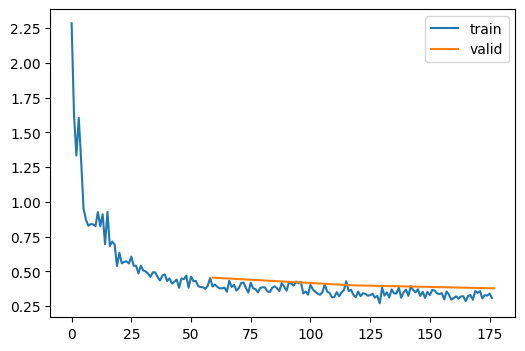

In [66]:
model = get_model(act_gr)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[lsuvcb])
learn.fit(3)

## BatchNorm

Sergey Ioffe and Christian Szegedy released ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) in 2015, saying:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

> Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

### LayerNorm

Simple version first


In [56]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1, 2, 3), keepdim=True)
        v = x.var((1, 2, 3), keepdim=True)
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mult + self.add

In [57]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [59]:
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=False, bias=True), nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.788,0.583,0,train
0.839,0.440,0,eval
0.865,0.368,1,train
0.862,0.375,1,eval
0.879,0.328,2,train
0.854,0.400,2,eval


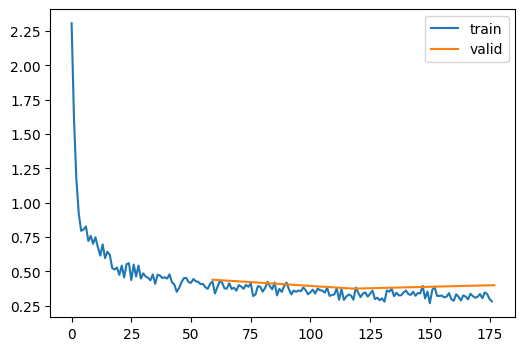

In [60]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

### BatchNorm

In [61]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.ones(nf, 1, 1))
        self.register_buffer('vars', torch.ones(1, nf, 1, 1))
        self.register_buffer('means', torch.ones(1, nf, 1, 1))

    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m, v = self.update_stats(x)
        else: m, v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds        

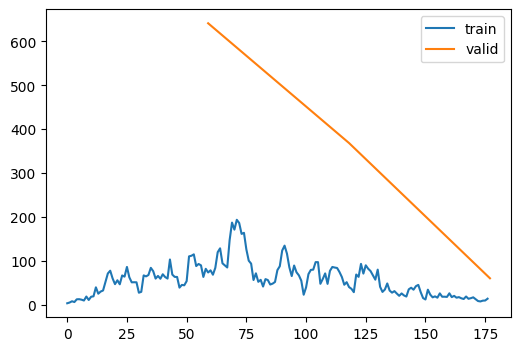

In [62]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

## Towards 90%...

In [63]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.836,0.449,0,train
0.861,0.383,0,eval
0.881,0.322,1,train
0.878,0.347,1,eval
0.892,0.292,2,train
0.866,0.381,2,eval


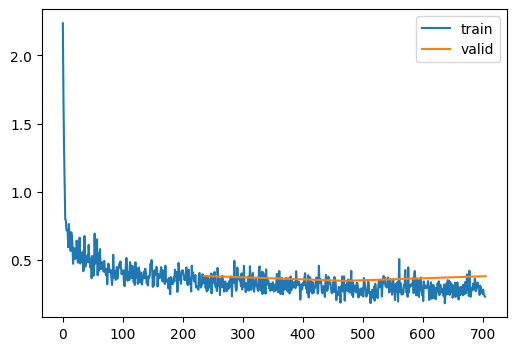

In [64]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.912,0.236,0,train
0.896,0.284,0,eval
0.918,0.224,1,train
0.897,0.285,1,eval


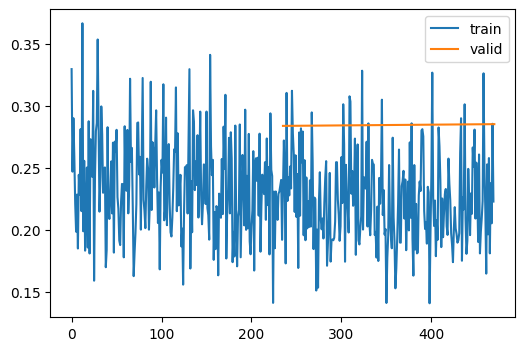

In [65]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)